Simulation and identification of RC circut
=============================

First part of this post will by about simulating basic RC circuit. We start from differential equation and then calculate transfer function. Secound part will be comparing step response of iurs modeal and real RC-circuit.
All simulation was done in Python. 

First we need to load librarys:

In [1]:
import numpy
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from sympy import init_session
init_session() 
import scipy.signal as sig
import scipy.optimize as opt
from IPython.display import Image

IPython console for SymPy 1.0 (Python 3.5.2-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.0/


Equations
---------
The scheme of circuit is shown in belowe figure:
![title](RC.png)
The input is of system is $u(t)$. The output $y(t)$ is voltage on capasitor. $R$ is resistance in Ohms and $C$ capacity in Farads. $q(t)$ is the charge on capacitor. From Ohms and Kirchoffs laws we could get equations:

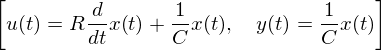

In [2]:
t = symbols('t')
u = Function('u')(t)
x = Function('x')(t)
y = Function('y')(t)
R, C = symbols('R C')
equations = [Eq(u, R*Derivative(x, t)+x/C), Eq(y, x/C)]
equations

The we gen calculate Laplace transform of our equation. Simpy currently can not do that, so we performe it manualy. $G(s)$ will be transfer function of this system.

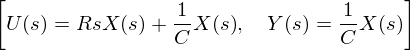

In [3]:
s = symbols('s')
U = Function('U')(s)
X = Function('X')(s)
Y = Function('Y')(s)
L_equations = [Eq(U, R*X*s+X/C), Eq(Y, X/C)]
L_equations

Then we could solve this system of equations and get transfer function:

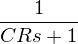

In [4]:
L_s = solve(L_equations,Y,X)
G = L_s[Y]/U
G

We get first order objet. Now we choose values for parameters and create transfer function for futures calculations:

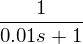

In [5]:
R_v = 100000
C_v =  100e-9
G_RC = G.subs(R, R_v).subs(C, C_v)
G_RC

In [6]:
num = Poly(fraction(G_RC)[0], s).all_coeffs()
num = [float(i) for i in num]
num = numpy.array(num)
den = Poly(fraction(G_RC)[1], s).all_coeffs()
den = [float(i) for i in den]
den = numpy.array(den)
G_n = sig.TransferFunction(num, den)

Now we could draw step response of our system:

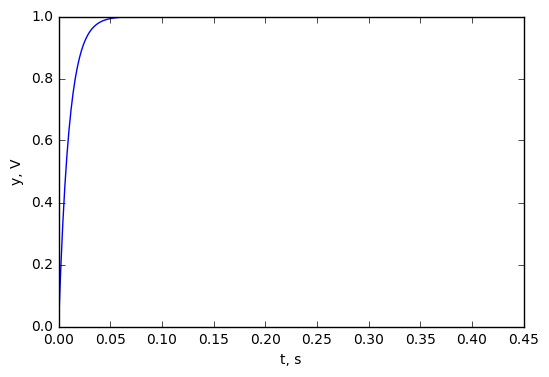

In [7]:
t = numpy.linspace(0, 0.4, 401)
step_response=G_n.step(T=t)
%matplotlib inline
fig = plt.axes()
fig.plot(step_response[0], step_response[1])
fig.set_xlabel('t, s')
fig.set_ylabel('y, V')

And last simulation - respons for square wave:

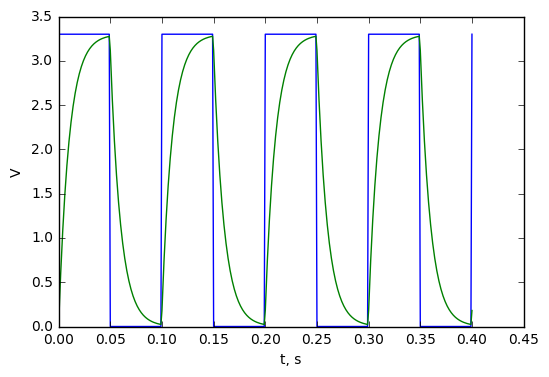

In [8]:
pwm = 3.3*(sig.square(2*numpy.pi*10*t)+1)/2
response = G_n.output(pwm, T=t)
fig = plt.axes()
fig.plot(t, pwm, t, response[1])
fig.set_xlabel('t, s')
fig.set_ylabel('V')

Experiment
----------
Simple program for STM32F401 was write. It generate pwm signal and gather voltage from capacitor by 12 bit ADC with frequwncy $1~kHz$. Belowe photo show measurements set-up:
![title](rc_foto.png)
Comparision beetween experimantal and simulated data is dhown in figure belowe:

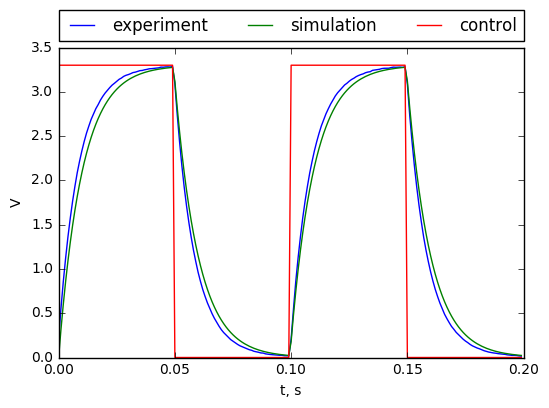

In [9]:
data = np.transpose(np.loadtxt('data.txt'));
data[0] = 3.3*data[0]/(2**12-1)
fig = plt.axes()
experiment, = fig.plot(t[0:200], data[0][0:200], label='experiment')
simulation, = fig.plot(t[0:200], response[1][0:200], label='simulation')
control, = fig.plot(t[0:200], pwm[0:200], label = 'control')
plt.legend(handles=[experiment, simulation, control])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
fig.set_xlabel('t, s')
fig.set_ylabel('V')

The mean squear error beetween simulation and data:

In [10]:
MSE = numpy.sum(numpy.power(data[0][0:200]-response[1][0:200], 2))
MSE

We could optimize value of $RC$ for best fit to data. I measured value of $R$ and got $101.3~k\Omega$, so this method could be used to obtain $C$.

In [11]:
def ErrorFunc(RC):
    t = numpy.linspace(0, 0.2, 201)
    pwm = 3.3*(sig.square(2*numpy.pi*10*t)+1)/2
    G_n = sig.TransferFunction(np.array([1]), np.array([RC[0], 1]))
    res = G_n.output(pwm, T=t)
    return numpy.sum(numpy.power(data[0][0:200]-res[1][0:200], 2))

ErrorFunc(np.array([R_v*C_v]))

In [12]:
output = opt.least_squares(ErrorFunc, np.array([R_v*C_v]))
[output.x, ErrorFunc(output.x)]

[array([ 0.00847335]), 0.21172472224806402]

Now it is possible to calculete exact value of $C$:

In [13]:
output.x[0]/101300

So the capacity is aobiut $83.6~nF$. Comparison of respons of simulation and data is shown belowe:

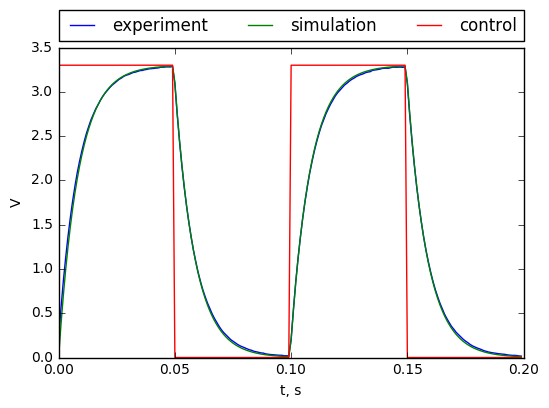

In [14]:
G_opt = sig.TransferFunction(np.array([1]), np.array([output.x[0], 1]))
res_opt = G_opt.output(pwm, T=t)
fig = plt.axes()
experiment, = fig.plot(t[0:200], data[0][0:200], label='experiment')
simulation, = fig.plot(t[0:200], res_opt[1][0:200], label='simulation')
control, = fig.plot(t[0:200], pwm[0:200], label = 'control')
plt.legend(handles=[experiment, simulation, control])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
fig.set_xlabel('t, s')
fig.set_ylabel('V')

Summary
---------
This notebook cover some interesting python features: symbolic calculations, simulation of the transfer functions and last but not list identification of simple, but real dynamic system. 
I measure the capacity by multimeter and get value $89.3~nF$, so achived result is nod very good. But data from model rather good fit to data. Model was build on breadboard so there could be parasitic capacitance and resistance. 